## Image Similarity with Online Contrastive Loss

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import models
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset

from tqdm import tqdm
from PIL import Image
from pathlib import Path
from shutil import copyfile
from itertools import combinations
from torch.utils.data.sampler import BatchSampler

from fastai.vision import get_image_files

cuda = torch.cuda.is_available()

In [3]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model

    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)


def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):

        #print("data", data.shape)
        #print("target", target.shape)

        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

In [4]:
class CloudDataset(Dataset):
    """
    A simple dataset meant to hold test/train paths and convert
    them to images when the Dataloader requests them
    """
    def __init__(self, df, train=True, transform=None, target_transform=None, download=False):
        
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.df = df

        if self.train:
            self.train_data = self.df['Path']
            self.train_labels = torch.Tensor(self.df['Label'].cat.codes).long()
        else:
            self.test_data = self.df['Path']
            self.test_labels = torch.Tensor(self.df['Label'].cat.codes).long()

    def __getitem__(self, index):
        
        if self.train:
            path, target = self.train_data[index], self.train_labels[index]
        else:
            path, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.open(path)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)        

In [5]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

class PairSelector:
    """
    Implementation should return indices of positive pairs and negative pairs that will be passed to compute
    Contrastive Loss
    return positive_pairs, negative_pairs
    """

    def __init__(self):
        pass

    def get_pairs(self, embeddings, labels):
        raise NotImplementedError

class HardNegativePairSelector(PairSelector):
    """
    Creates all possible positive pairs. For negative pairs, pairs with smallest distance are taken into consideration,
    matching the number of positive pairs.
    """

    def __init__(self, cpu=True):
        super(HardNegativePairSelector, self).__init__()
        self.cpu = cpu

    def get_pairs(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)

        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]

        negative_distances = distance_matrix[negative_pairs[:, 0], negative_pairs[:, 1]]
        negative_distances = negative_distances.cpu().data.numpy()
        top_negatives = np.argpartition(negative_distances, len(positive_pairs))[:len(positive_pairs)]
        top_negative_pairs = negative_pairs[torch.LongTensor(top_negatives)]

        return positive_pairs, top_negative_pairs


class OnlineContrastiveLoss(nn.Module):
    """
    Online Contrastive loss
    Takes a batch of embeddings and corresponding labels.
    Pairs are generated using pair_selector object that take embeddings and targets and return indices of positive
    and negative pairs
    """

    def __init__(self, margin, pair_selector):
        super(OnlineContrastiveLoss, self).__init__()
        self.margin = margin
        self.pair_selector = pair_selector

    def forward(self, embeddings, target):
        positive_pairs, negative_pairs = self.pair_selector.get_pairs(embeddings, target)
        if embeddings.is_cuda:
            positive_pairs = positive_pairs.cuda()
            negative_pairs = negative_pairs.cuda()
        positive_loss = (embeddings[positive_pairs[:, 0]] - embeddings[positive_pairs[:, 1]]).pow(2).sum(1)
        negative_loss = F.relu(
            self.margin - (embeddings[negative_pairs[:, 0]] - embeddings[negative_pairs[:, 1]] + 1e-9).pow(2).sum(
                1).sqrt()).pow(2)
        loss = torch.cat([positive_loss, negative_loss], dim=0)
        return loss.mean()

In [6]:
class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            #print(indices)
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size


In [7]:
class Identity(nn.Module):
    """
    A small helper module that we'll use to
    replace the fully-connected head of a pretrained network
    """
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [8]:
data = Path("data")
train = pd.read_csv(data/'train_image_similarity.csv')
valid = pd.read_csv(data/'valid_image_similarity.csv')
train['Label'] = train['Label'].astype('category')
valid['Label'] = valid['Label'].astype('category')

train_dataset = CloudDataset(train, train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                                 
                             ]))
test_dataset = CloudDataset(valid, train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                            ]))

In [9]:
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=20, n_samples=2)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=20, n_samples=2)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
margin = 1.
embedding_net = models.resnet18(pretrained=True)
embedding_net.fc = Identity()

model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
#Save the model
torch.save(embedding_net.state_dict(), "data/contrastive_state_dict")

## Find Similar Pairs

Now that we've trained our model, let's use it to try to find similar images across both the training and test sets.


In [10]:
TRAIN_FOLDER = 'data/train_images_350x525/'
TEST_FOLDER = 'data/test_images_350x525/'
train_images = get_image_files(TRAIN_FOLDER)
test_images = get_image_files(TEST_FOLDER)

In [11]:
embedding_net = models.resnet18(pretrained=True)
embedding_net.fc = Identity()
embedding_net.load_state_dict(torch.load("data/contrastive_state_dict"))
embedding_net = embedding_net.eval().cuda()

In [12]:
def get_embedding_from_path(img_path):
    #load image
    img = Image.open(img_path)

    #convert to tensor
    x = transforms.ToTensor()(img).unsqueeze(0).cuda()

    #send through model
    out = embedding_net(x).detach()
    
    return out

def get_embeddings_from_paths(paths):
    """
    Get all embeddings for the images in a list of paths
    """
    embeddings = []

    for img in tqdm(paths):
        embedding = get_embedding_from_path(img).cpu().numpy()
        embeddings.append(embedding)

    embeddings = np.array(embeddings).squeeze()
    return embeddings

In [13]:
train_embeddings = get_embeddings_from_paths(train_images)
train_embeddings.shape

100%|██████████| 5546/5546 [00:52<00:00, 106.04it/s]


(5546, 28160)

In [14]:
test_embeddings = get_embeddings_from_paths(test_images)
test_embeddings.shape

100%|██████████| 3698/3698 [00:34<00:00, 107.89it/s]


(3698, 28160)

In [15]:
# The test/train split was created by random splitting. 
# This means some of our pairs exist in train, some in test and some across train/test
# To handle this, we'll put them all together before trying to match them up again

all_embeddings = np.concatenate((train_embeddings, test_embeddings))

In [ ]:
def get_distance_between_embeddings(embeddings1, embeddings2):
    """
    Given two sets of embeddings, calculate the distance between both
    """
    
    distance = np.zeros((len(embeddings1), len(embeddings2)))
    
    for i, row in enumerate(embeddings1):
        if i % 250 == 0:
            print(i, '/', len(embeddings1))

        row = row[np.newaxis,:]
        distance_row = np.sqrt(np.square(row - embeddings2).sum(axis=1))
        distance[i,:] = distance_row
        
    return distance

In [ ]:
all_distances = get_distance_between_embeddings(all_embeddings, all_embeddings)
# Checkpoint
np.save("data/all_distances", all_distances)

In [17]:
all_distances = np.load("data/all_distances.npy")

In [18]:
def find_similar_pairs(distances, threshold=0.430116263):
    """
    Find pairs of images that are very similar to one another according to the Euclidean distance
    between their feature vectors.
    """
    
    def getLookup(distances, threshold):
        pairLookup = {}

        for i, row in enumerate(distances):

            sortedIndices = np.argsort(row)

            minIndex = sortedIndices[0]
            minVal = row[minIndex]

            # We want to ignore any distances of zero because that means the images are identical
            # In this case, we get the second-smallest distance
            if minVal == 0:
                minIndex = sortedIndices[1]
                minVal = row[minIndex]

            if minVal < threshold:
                pairLookup[i] = minIndex

        return pairLookup

    # We get the minimum distance from the first set to the second and from the second to the first
    lookup1 = getLookup(distances, threshold)
    lookup2 = getLookup(distances.T, threshold)

    finalLookup = {}

    # We only consider them to be pairs if they both point to one another
    for key, value in lookup1.items():

        if value in lookup2 and lookup2[value] == key:
            finalLookup[key] = value

    return finalLookup

In [20]:
all_pairs = find_similar_pairs(all_distances)

In [21]:
# Now we break the pairs up according to the splits to which they belong
# This will be helpful when creating a validation set later
train_train_pairs = {}
train_test_pairs = {}
test_test_pairs = {}

for key, value in all_pairs.items():
    
    if key < len(train_images) and value < len(train_images):
        train_train_pairs[key] = value        
        
    elif key < len(train_images) and value >= len(train_images):
        train_test_pairs[key] = value - len(train_images) #Note that we're only keeping train->test mappings
        
    elif key >= len(train_images) and value < len(train_images):
        train_test_pairs[value] = key - len(train_images) #Note that we're only keeping train->test mappings
        
    elif key >= len(train_images) and value >= len(train_images):
        test_test_pairs[key - len(train_images)] = value - len(train_images)
        
    else:
        raise("Supposed to be unreachable:", key, value)
    

In [22]:
print(len(train_train_pairs))
print(len(train_test_pairs)) 
print(len(test_test_pairs))

1770
1202
798


In [23]:
# Checkpoint
np.save("data/train_train_pairs", train_train_pairs)
np.save("data/train_test_pairs", train_test_pairs)
np.save("data/test_test_pairs", test_test_pairs)

## Visualizing Pairs

Now that we've created our pairs, let's look at them manually to make sure they look OK. Let's keep an eye out for any that seem problematic.

In [ ]:
#We'll dump them all into a directory for manual review
i = 0

if os.path.isdir("data/tt"):
    shutil.rmtree('data/tt')

os.mkdir('data/tt')

seen = {}

for (k, v) in train_train_pairs.items():
    
    if k not in seen and v not in seen:
        seen[k] = True
        seen[v] = True
    else:
        continue
        
    id1 = f"{i:05d}"
    id2 = f"{i+1:05d}"
   
    path1 = train_images[k]
    path2 = train_images[v]
    
    newPath1 = 'data/tt/' + id1 + "_" + str(k) + "_" + str(path1.name)
    newPath2 = 'data/tt/' + id2 + "_" + str(v) + "_" + str(path2.name)
    copyfile(path1, newPath1)
    copyfile(path2, newPath2)
    
    i = i + 2

In [26]:
def showTrainPair(idx1, idx2):
    img1 = Image.open(train_images[idx1])
    img2 = Image.open(train_images[idx2])
     
    fig=plt.figure(figsize=(10, 4))
    columns = 2
    rows = 1
    fig.add_subplot(1, 2, 1)
    plt.imshow(img1)
    fig.add_subplot(1, 2, 2)
    plt.imshow(img2)
    
    plt.show()
    

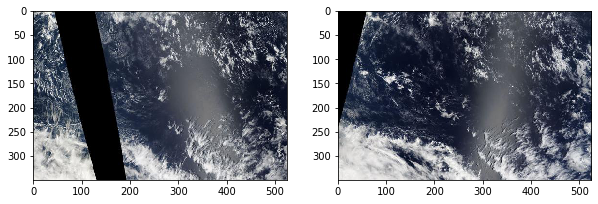

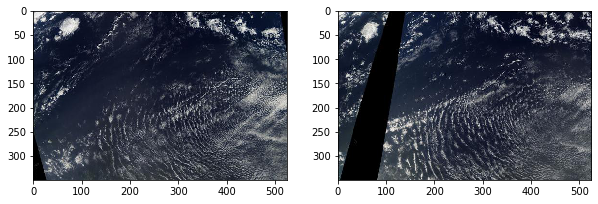

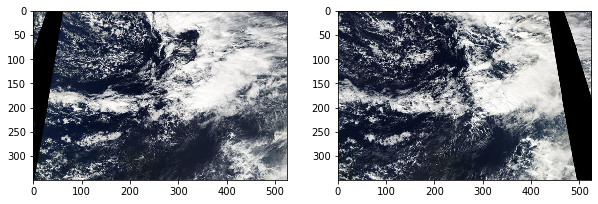

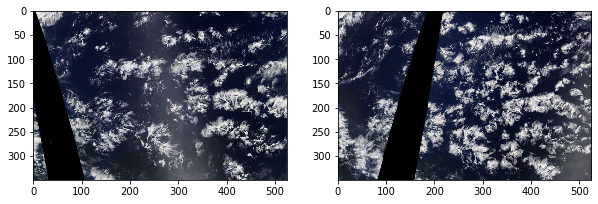

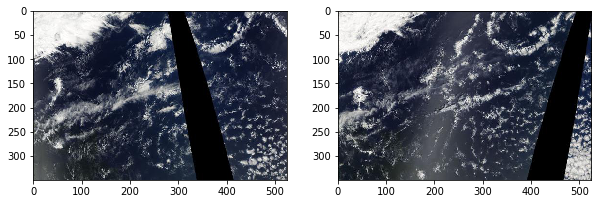

In [27]:
sample = {k: train_train_pairs[k] for k in list(train_train_pairs.keys())[:5]}

for k,v in sample.items():
    showTrainPair(k,v)

### Problematic Pairs:
- 179, 1543
- 357, 1601
- 587, 1295
- 1056, 1822
- 1209, 1894
- 1439, 2402
- 1740, 2253
- 3262, 3933
- 5459, 3268
- 3325, 3945
- 3736, 4506
- 3834, 4814
- 4495, 4886
- 4639, 5179
- 4897, 5087

30 / 1770 = 0.0169491525

So about 1% of our images aren't truly pairs. This isn't too bad, but there's probably still room for improvement.


The two satellites orbit the earth in such a way that they leave black lines in the images they capture. Due to the orbits one satellite leaves black lines that go from the top-left to bottom-right (\) and the other leave black lines that go from bottom-left to top-right (/).

Below notice that many of the problematic pairs have black lines that point in the same direction. This is interesting because this should automatically preclude them from being paired together as it means the images came from the same satellite. Later, we may wish to address this.